# CIFAR10을 CNN으로 학습하기

## 여러 학습 방법으로 비교

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init 
import torchvision.datasets as dset
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

from torch.optim import lr_scheduler

# hyper parameter들 
batch_size = 8
learning_rate = 0.002
num_epoch = 150 # 제대로 학습시키려면 100번 이상
# but 이론시간의 기법들의 효과만 볼 거라 최소한의 epoch 1만 돌려 성능 측정

#num_epoch = 60 # (7) learning rate decay

## 1. CIFAR10 train, test dataset 가져오기 (163 MB)
MNIST : 11MB

In [2]:
# cifar10은 10개의 카테고리로 dataset이 존재 
# 특정 사진이 들어오면 어떤 카테고리에 속하는지 분류하는 dataset => SL
cifar_train = dset.CIFAR10("CIFAR10/", train=True, transform = transforms.ToTensor(), target_transform=None, download = True)
cifar_test = dset.CIFAR10("CIFAR10/", train=False, transform = transforms.ToTensor(), target_transform=None, download = True)


Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10/
Files already downloaded and verified


(2) Data augmentation

In [3]:
# cifar10은 10개의 카테고리로 dataset이 존재 
# 특정 사진이 들어오면 어떤 카테고리에 속하는지 분류하는 dataset => SL
cifar_train = dset.CIFAR10("CIFAR10/", train=True, transform = transforms.ToTensor(), target_transform=None, download = True)
# (2) Data augmentation 
'''
# 학습할 때 data의 양을 늘리는 것이 목적이기에 test dataset에는 안 하는게 맞음 
cifar_train = dset.CIFAR10("CIFAR10/", train=True,
                         transform = transforms.Compose([
                             transforms.Scale(36),# 36만큼 키운 후 
                             transforms.CenterCrop(32), # 32만큼 center crop
                             transforms.RandomHorizontalFlip(), # 좌우반전해줘
                             transforms.Lambda(lambda x: x.rotate(90)), # 90도 회전해줘
                             transforms.ToTensor()
                         ]))
'''
cifar_test = dset.CIFAR10("CIFAR10/", train=False, transform = transforms.ToTensor(), target_transform=None, download = True)

Files already downloaded and verified
Files already downloaded and verified


(4) Data Normalization

In [4]:
## (4) Data Normalization
# 학습할 때도 data Normalization을 하고 test 할 때도 data Normalization


cifar_train = dset.CIFAR10("CIFAR10/", train=True, transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # data Normalization
]), target_transform=None, download = True)
cifar_test = dset.CIFAR10("CIFAR10/", train=False, transform = transforms.Compose([
    transforms.ToTensor(),                                                                               
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # data Normalization
]), target_transform=None, download = True)

Files already downloaded and verified
Files already downloaded and verified


## 2. 대략적인 데이터 형태

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cifar_train 길이:  50000
cifar_test 길이:  10000
image data 형태:  torch.Size([3, 32, 32])
label:  9


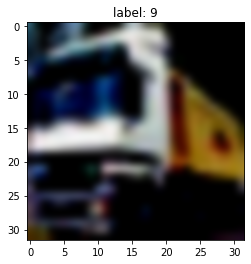

In [5]:
print("cifar_train 길이: ", len(cifar_train))
print("cifar_test 길이: ", len(cifar_test))

#데이터 하나의 형태
image, label = cifar_train.__getitem__(1) # 첫번째 데이터
print("image data 형태: ", image.size()) # [# of channel, width, height]
print("label: ", label) # 트럭에 해당! 

# 그리기
img = image.numpy() # image 타입을 numpy로 변환 (3, 32, 32)

# [# of channel, width, height] -> [width, height, # of channel]
# (3, 32, 32) -> (32, 32, 3) 형태로 저장한 것이 img2
r, g, b = img[0, :, :], img[1, :, :], img[2, :, :]
#img = img.reshape(img.shape[1], img.shape[2], img.shape[0])
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:, :, 0], img2[:, :, 1], img2[:, :, 2] = r, g, b

plt.title("label: %d" %label)
plt.imshow(img2, interpolation='bicubic')
plt.show()

In [6]:
# 우리가 만든 model을 입력하면 test_loader를 batch_size만큼 떼어오는
# 두 개의 전달인자를 넣으면 test data에 대한 예측 성능을 출력하는 함수
# 학습 관여하지 않음 
# 모델에 대해 forwardpropagation한 결과값이 진짜 label과 같냐 다르냐만 측정
# backpropagation는 하지 않음 
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader): # dloader를 이용해 imgs와 labels 읽어옴 
        img = Variable(imgs, volatile=True).cuda() # x
        # Variable : 모델에 데이터를 넣을 때 씌워주는 container
        # label = Variable(labels) # y
        label = Variable(labels).cuda()
        # .cuda() : GPU 로드되기 위해성
        
        # output : 1024개 data에 대한 결과 = output layer 
        # output layer  : 10개의 유닛, 각 유닛이 0 or 1에 해당 -> 1일 경우 예측한 label 
        # output의 shape = (1024, 10)
        output = imodel.forward(img) # forward prop 
        # output_index에 label 저장
        # torch.max : 10개로 이루어진 결과값 중 가장 높은 곳의 index return해줘!  
        _, output_index = torch.max(output, 1)
        
        # label : 1024개로 이루어진 y값 = 정답 label 
        total += label.size(0) # batch_size를 total count(data 개수 세는)
        # y값과 y hat(예측한 값)이 같은지 다른지 축적 
        correct += (output_index == label).sum().float()
    # 요 한 번의 loop가 1024개의 data에 대한 !     
    
    # 전체 test data 만장에 대한 Accr 측정
    print("Accuracy of Test Data: {}".format(100*correct/total))

## 3. 데이터 로드함수

In [7]:
train_loader = torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)                                       

## 4. 모델 선언

(3) weight initialization, (6) batch normalization

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d( 3, 16, 3, padding = 1),
            nn.LeakyReLU(),
            #nn.ReLU(),
            #nn.ELU(),
            nn.BatchNorm2d(16), # (6) batch normalization -> activation function 다음에 써줌 
            # dropout에서 몇 퍼센트의 unit 끌 건지 p에 해당하는 값
            # 이 layer에서 unit의 20%를 랜덤하게 꺼줘
            nn.Dropout2d(0.2), # (2) drop out
            nn.Conv2d(16, 32, 3, padding = 1), 
            nn.LeakyReLU(),
            #nn.ReLU(),
            #nn.ELU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding = 1),
            nn.LeakyReLU(),
            #nn.ReLU(),
            #nn.ELU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2, 2)
        )
        
        # 가장 마지막 층 
        self.fc_layer = nn.Sequential(
            nn.Linear(64*8*8, 100), # fully connected layer 
            nn.LeakyReLU(),
            #nn.ReLU(),
            #nn.ELU(),
            nn.BatchNorm1d(100), # unit들이 한 줄로 늘어선 값들이 나옴 
            nn.Dropout2d(0.2),
            nn.Linear(100, 10)
        )
        
        
        # (3) weight initialization
        for m in self.modules():
            # nn.Conv2d layer와 nn.Linear의 parameter들을 초기화하는데 kaiming_normal로 해줘
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data) # ReLU일 때
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
        

    def forward(self, x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
            
        return out

model = CNN().cuda()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


## 5. loss, optimizer

(6) Adam optimizer, (7) learning rate decay

In [9]:
loss_func = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # (6) Adam optimizer

# parameter : 옵티마이저, step_size만큼 learing rate 바꿈  
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)  # (7) learning rate decay

## 6. 학습

In [10]:
model.train()
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = Variable(image).cuda()
        y_ = Variable(label).cuda()
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()

        if j % 1000 == 0:
          print("%d.." %i)
          print(j, loss)

0..
0 tensor(2.6682, device='cuda:0', grad_fn=<NllLossBackward>)
0..
1000 tensor(2.4904, device='cuda:0', grad_fn=<NllLossBackward>)
0..
2000 tensor(1.4758, device='cuda:0', grad_fn=<NllLossBackward>)
0..
3000 tensor(0.8713, device='cuda:0', grad_fn=<NllLossBackward>)
0..
4000 tensor(1.5211, device='cuda:0', grad_fn=<NllLossBackward>)
0..
5000 tensor(1.0491, device='cuda:0', grad_fn=<NllLossBackward>)
0..
6000 tensor(0.8162, device='cuda:0', grad_fn=<NllLossBackward>)
1..
0 tensor(0.9773, device='cuda:0', grad_fn=<NllLossBackward>)
1..
1000 tensor(1.4451, device='cuda:0', grad_fn=<NllLossBackward>)
1..
2000 tensor(1.5660, device='cuda:0', grad_fn=<NllLossBackward>)
1..
3000 tensor(1.0807, device='cuda:0', grad_fn=<NllLossBackward>)
1..
4000 tensor(0.9752, device='cuda:0', grad_fn=<NllLossBackward>)
1..
5000 tensor(1.5229, device='cuda:0', grad_fn=<NllLossBackward>)
1..
6000 tensor(0.7817, device='cuda:0', grad_fn=<NllLossBackward>)
2..
0 tensor(1.1490, device='cuda:0', grad_fn=<NllLoss

In [11]:
model.eval()

ComputeAccr(test_loader, model) # epoch = 1이지만 10보다 약간 성능 좋아짐

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


Accuracy of Test Data: 77.61000061035156


In [14]:
netname = '/content/gdrive/My Drive/Colab Notebooks/실습04/nets/mlp_weight34.pkl'
torch.save(model, netname, )

## 모델 불러와서 성능 측정

In [15]:
netname = '/content/gdrive/My Drive/Colab Notebooks/실습04/nets/mlp_weight34.pkl'
model = torch.load(netname)

model.eval()
ComputeAccr(test_loader, model) # epoch = 1이지만 10보다 약간 성능 좋아짐

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


Accuracy of Test Data: 77.61000061035156
